In [1]:
%matplotlib inline

In [2]:
import scipy.stats
import scipy.optimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numdifftools
from copy import copy

# Create Templates and Toy Data

As an example, we use a 2D Gaussian distribution. We will then only "measure" the marginalized distributions, extract the pearson correlation coefficients for the bins, and then try to extract the initial parameters.
We create the template data with a factor of 10 more statistics, drawn from the same distribution (so we assume we understand our MC, and this only about the extraction of the parameters of interest).

In [3]:
used_range = (-2, 2)
bins = 10

In [4]:
N = 10000
mean = np.array([0, 0])
std = np.array([1, 1])
rho = 0.3

corr = np.array([
    [1, rho],
    [rho, 1]
])
cov = np.outer(std, std) * corr


def create_data(mean, cov, N):
   
    #N = scipy.stats.poisson.rvs(N)
    toy_data = scipy.stats.multivariate_normal.rvs(
        mean=mean,
        cov=cov,
        size=N
    )

    toy_data = pd.DataFrame({
        "x": toy_data[:, 0],
        "y": toy_data[:, 1]
    })

    data = {
        "x": np.histogram(toy_data.x.values, bins=10, range=used_range)[0],
        "y": np.histogram(toy_data.y.values, bins=10, range=used_range)[0],
    }
    
    return toy_data, data

In [5]:
toy_data, data = create_data(mean, cov, N)

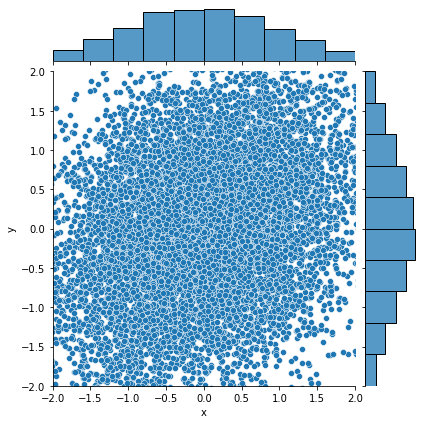

In [6]:
# This is what our measurement has given us
sns.jointplot(x=toy_data.x, y=toy_data.y, xlim=used_range, ylim=used_range, marginal_kws=dict(bins=bins, binrange=used_range))
plt.savefig("bias-2dplot.pdf")

In [7]:
bin_edges = np.linspace(*used_range, num=bins+1)

In [8]:
# Theory tells us what to expect in the margins
margin_x = np.array([scipy.stats.norm.cdf(u, loc=mean[0], scale=std[0]) - scipy.stats.norm.cdf(l, loc=mean[0], scale=std[0]) for l, u in zip(bin_edges, bin_edges[1:])])
margin_y = np.array([scipy.stats.norm.cdf(u, loc=mean[1], scale=std[1]) - scipy.stats.norm.cdf(l, loc=mean[1], scale=std[1]) for l, u in zip(bin_edges, bin_edges[1:])])

In [9]:
# Used range covers that amount of the theory space
covered_phase_space_2d = scipy.integrate.nquad(lambda x, y: scipy.stats.multivariate_normal.pdf((x, y), mean=mean, cov=cov), (used_range, used_range))[0]
covered_phase_space_2d

0.9131882712734904

In [10]:
# Used range covers that amount of the theory space
scipy.integrate.quad(lambda x: scipy.stats.norm.pdf(x, loc=mean[0], scale=std[0]), *used_range)[0], sum(margin_x)
covered_phase_space_1d = sum(margin_x)

In [11]:
def L(x, *pars):
    data, sig = x 
    nu_per_bin = pars * sig / sum(sig)
        
    return -2 * sum(data * np.nan_to_num(np.log(sum(nu_per_bin)))- nu_per_bin)

In [12]:
%%time
# Now bootstrap correlation from data
toys = []

for bootstrap in range(0, 100000):
    data_bootstrap = toy_data.sample(frac=1.0, replace=True)
    bootstrap = {
        "x": np.histogram(data_bootstrap.x.values, bins=10, range=used_range)[0],
        "y": np.histogram(data_bootstrap.y.values, bins=10, range=used_range)[0],
    }
    
    toy_results = []
    for margin in ["x", "y"]:
        for Bin in range(10):
            toy_results.append(
                bootstrap[margin][Bin]
            )
    toys.append(toy_results)

CPU times: user 2min 1s, sys: 108 ms, total: 2min 1s
Wall time: 2min 1s


In [13]:
toys = np.array(toys)

In [14]:
correlation_matrix = np.corrcoef(toys, rowvar=False)
# "Fix" correlation matrix, as we know there is no correlation in neighbouring bins of the same margin
for offset in range(0, 2*10, 10):
    for i in range(offset, offset+10):
        for j in range(offset, offset+10):
            if i != j:
                correlation_matrix[i, j] = 0

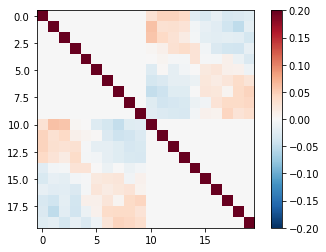

In [15]:
plt.imshow(correlation_matrix, vmin=-0.2, vmax=0.2, cmap=plt.get_cmap("RdBu_r"))
plt.colorbar()
plt.savefig("bias-datacorrelation.pdf")

# Now Fit

In [16]:
central_values_data = np.array([*data["x"], *data["y"]])
covariance_data = np.outer(central_values_data, central_values_data) ** 0.5 * correlation_matrix

central_values_template = np.array([*margin_x, *margin_y])

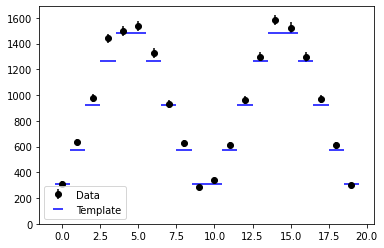

In [17]:
plt.errorbar(range(20), central_values_data, yerr=covariance_data.diagonal() ** 0.5 , marker="o", color="black", label="Data", ls="")
plt.errorbar(range(20), N*sum(margin_x)*central_values_template, xerr=0.5, marker="", color="blue", label="Template", ls="")
plt.legend()
plt.ylim(0, None)
plt.savefig("bias-2dplot.pdf")

In [18]:
def chi2_2d(data, *x):
    delta = (data - central_values_template * x)
    return delta.transpose() @ np.linalg.inv(covariance_data) @ delta

fit_result = scipy.optimize.minimize(lambda x: chi2_2d(central_values_data, *x), x0=N, method="SLSQP")
hesse = numdifftools.Hessian(
    lambda x: chi2_2d(central_values_data, *x))(fit_result.x)
fit_result.covariance =  np.linalg.inv(hesse / 2)
fit_result

 covariance: array([[5240.98671657]])
        fun: 24.239006123120824
        jac: array([3.33786011e-06])
    message: 'Optimization terminated successfully'
       nfev: 14
        nit: 7
       njev: 7
     status: 0
    success: True
          x: array([9976.25893031])

In [19]:
def chi2_1d(data, *x):
    delta = (data[:10] - central_values_template[:10] * x )
    return delta.transpose() @ np.linalg.inv(covariance_data[:10, :10]) @ delta

fit_result = scipy.optimize.minimize(lambda x: chi2_1d(central_values_data, *x), x0=N, method="SLSQP")
hesse = numdifftools.Hessian(
    lambda x: chi2_1d(central_values_data, *x))(fit_result.x)
fit_result.covariance =  np.linalg.inv(hesse / 2)
fit_result

 covariance: array([[10481.74266533]])
        fun: 19.40358695172317
        jac: array([-0.0009191])
    message: 'Optimization terminated successfully'
       nfev: 2
        nit: 1
       njev: 1
     status: 0
    success: True
          x: array([10000.])

In [20]:
fit_result.covariance[0, 0] ** 0.5, fit_result.x[0] ** 0.5

(102.38038222885733, 100.0)

In [21]:
%%time
toy_results_2d = []
toy_results_1d = []

for _ in range(0, 5000):
    _, data = create_data(mean, cov, scipy.stats.poisson.rvs(N))
    central_values_data = np.array([*data["x"], *data["y"]])
    covariance_data = np.outer(central_values_data, central_values_data) ** 0.5 * correlation_matrix

    toy_results_2d.append(scipy.optimize.minimize(lambda x: chi2_2d(central_values_data, *x), x0=N, method="SLSQP").x[0])
    toy_results_1d.append(scipy.optimize.minimize(lambda x: chi2_1d(central_values_data, *x), x0=N, method="SLSQP").x[0])

CPU times: user 2min 12s, sys: 5min 49s, total: 8min 1s
Wall time: 1min 5s


In [22]:
np.mean(toy_results_2d), np.std(toy_results_2d)

(9988.503010102195, 100.03174430104195)

In [23]:
np.mean(toy_results_1d), np.std(toy_results_1d)

(9988.714247050866, 101.27321557551132)

In [24]:
np.mean(toy_results_2d) / np.mean(toy_results_1d)

0.9999788524385175

In [25]:
np.std(toy_results_2d) / np.std(toy_results_1d)

0.9877413660915734

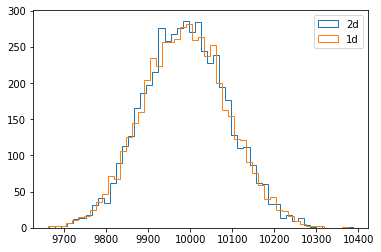

In [26]:
plt.hist(np.array(toy_results_2d), bins=50, label="2d", histtype="step")
plt.hist(np.array(toy_results_1d), bins=50, label="1d", histtype="step")
#plt.xlim(9950, 10050)
plt.legend()

In [27]:
covered_phase_space_1d,covered_phase_space_2d,

(0.9544997361036416, 0.9131882712734904)